# Sentiment analysis

# Imports

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

nltk.download("punkt")
nltk.download("stopwords")
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\baheu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baheu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\baheu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df = pd.read_csv('./data/data_JV_2020_2023_tokenised.csv')

In [30]:
df['title_y'] = df['title_y'].fillna('')
#df2 = df[df['title_y'].str.contains('Cyberpunk')].copy()
df2 = df.iloc[:10000,:].copy()

In [31]:
df2.shape

(10000, 11)

# Data preprocessing

In [32]:
ps = PorterStemmer()

def stem_word(word):
    return ps.stem(word)

def stem_column(column):
    return column.apply(lambda x: ' '.join([stem_word(word) for word in nltk.word_tokenize(x)]))

def remove_stop_words(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))  
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [33]:
df2['text'] = df2['text'].fillna('')

In [34]:
df2["avis_stopwords"] = df2["text"].apply(remove_stop_words)
df2["avis_preprocess"] = stem_column(df2["avis_stopwords"])

# Modelisation (transfer learning)

In [35]:
MODEL_NAME = "LiYuan/amazon-review-sentiment-analysis"
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)
MODEL = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, from_tf = False)

sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=TOKENIZER)

In [36]:
#df2 = df.iloc[:5000,:].copy()

In [37]:
def get_sentiment(text):
    
    max_length = 512
    text = text[:max_length]
    result = sentiment_task(text)[0]
    
    return result["label"]

df2['sentiment_HF'] =df2['text'].apply(get_sentiment)
# pour 5k lignes ca prend 13min donc pour 600k lignes ca prendra environ 7h

In [38]:
df2['sentiment_HF'] = df2['sentiment_HF'].apply(lambda x : x[0])
df2['sentiment_HF'] = df2['sentiment_HF'].astype('int')

# Evaluation performances

In [39]:
df2['rating']=df2['rating'].astype('int')

In [40]:
df2[['sentiment_HF','rating']]

,sentiment_HF,rating
0,5,4
1,4,5
2,5,5
3,5,5
4,1,1
...,...,...
9995,5,5
9996,5,5
9997,1,1
9998,5,5


In [41]:
df2['sentiment_pred'] = df2['sentiment_HF'].apply(lambda x : 1 if x == 1 else 1 if x == 2 else 2 if x == 3 else 3)
df2['sentiment_true'] = df2['rating'].apply(lambda x : 1 if x == 1 else 1 if x == 2 else 2 if x == 3 else 3)
df2['perf_count'] = df2.apply(lambda row: 1 if row['sentiment_pred'] == row['sentiment_true'] else 0, axis=1)


In [42]:
print(f"Performance : {round(df2['perf_count'].sum()/df2.shape[0]*100,2)}% de bonnes predictions")

Performance : 87.74% de bonnes predictions


# Récuperation des mots responsables des bons sentiments

In [43]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialiser l'analyseur de sentiments
sia = SentimentIntensityAnalyzer()

# Fonction pour extraire les mots les plus fréquents des commentaires positifs
def mots_positifs(commentaires):
    mots_positifs = []
    mots_a_exclure = ['br', 'game','great','like','playing','one','good','games','play','love','get','well','really','would','time','use',
                      'nice','also','nice','even','much','playing','case','got','loves','played']
    
    for commentaire in commentaires:
        if sia.polarity_scores(commentaire)['compound'] > 0:
            mots = [mot.lower() for mot in word_tokenize(commentaire) if mot.isalpha() and mot.lower() not in stopwords.words('english') and mot.lower() not in mots_a_exclure]
            mots_positifs.extend(mots)
            
    return mots_positifs

# Extraire les mots les plus fréquents dans les commentaires positifs
mots_freq_positifs = FreqDist(mots_positifs(df2[df2['sentiment_pred'] == 3]['text']))

In [44]:
print("Les mots les plus fréquents associés aux commentaires positifs :")
for mot, freq in mots_freq_positifs.most_common(200):
    print(f"{mot}: {freq}")

Les mots les plus fréquents associés aux commentaires positifs :
controller: 1228
switch: 916
original: 807
new: 699
story: 682
easy: 603
first: 564
still: 542
lot: 504
better: 503
little: 492
played: 490
best: 478
feel: 468
price: 450
way: 438
back: 436
perfect: 435
hours: 428
make: 409
could: 407
son: 398
controllers: 394
graphics: 392
old: 390
buy: 390
quality: 385
xbox: 376
want: 376
recommend: 372
characters: 371
work: 359
pretty: 358
gift: 355
far: 346
amazing: 343
worth: 342
made: 340
buttons: 337
think: 334
go: 332
long: 331
headset: 331
different: 331
system: 328
remake: 327
since: 326
happy: 326
definitely: 323
bit: 323
nintendo: 323
though: 322
series: 319
know: 317
loved: 317
feels: 310
kids: 310
part: 307
product: 306
many: 304
used: 297
everything: 294
super: 293
every: 292
looks: 289
came: 284
gameplay: 282
say: 281
see: 280
need: 280
awesome: 274
put: 271
makes: 266
right: 264
hard: 263
fit: 259
thing: 259
gaming: 259
find: 258
using: 258
take: 255
look: 255
things: 253

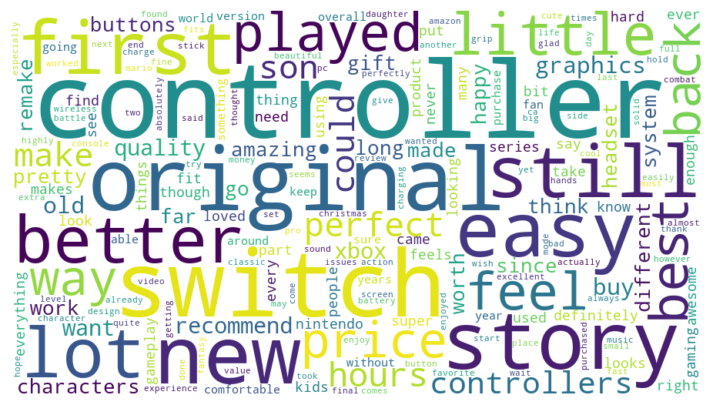

In [45]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Créer l'objet WordCloud
wordcloud = WordCloud(width=900, height=500, background_color='white').generate_from_frequencies(mots_freq_positifs)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Champs lexicaux

In [66]:
categories = {
    'graphismes': ['graphism','graphics','graphic','look','visuals','art','design','aesthetics','rendering','resolution','detail','texture','animation'],
    'gameplay': ['gameplay','combat','fight','experience','mechanics','controls','interaction','challenge','pace','flow','depth','strategy','tactics'],
    'enfants': ['kids','kid','son','daughter','sons','daughters','children','child','young ones','offspring','little ones','family'],
    'musiques_sons': ['headset','music','musics','sound','sounds','audio','ambient','score','tracks','effects','voiceover','dialogue'],
    'jeu_bug': ['bugs','bug','glitch','glitches','errors','crashes','issues','problems','flaws','defects'],
    'histoire_scenario': ['story','characters','character','feel','feelings','feels','narrative','plot','lore','world-building','dialogue','twists','development'],
    'se_joue_avec_manette': ['controller','controllers','gamepad','joystick','input device','remote','pad','analog stick','d-pad','motion controls'],
    'open_world': ['open','liberty','freedom','sandbox','exploration','non-linear','vast','expansive','immersive','world design','environment','map size','boundless'],
    'jeu_facile': ['easy','accessible','simple','casual','beginner-friendly','user-friendly','approachable','undemanding','relaxed'],
    'jeu_faisant_partie_dune_saga': ['first','better','improved','sequel','prequel','series','franchise','installment','continuation','universe','lore','canon'],
    'jeu_original': ['original','new','innovative','unique','fresh','creative','novel','groundbreaking','distinctive','trailblazing','avant-garde'],
    'rapport_qualite_prix': ['price','prices','worth','quality','works','buy','bought','value','affordable','cost-effective','investment','budget-friendly','expensive'],
    'jeu_fun': ['fun','happy','enjoyable','entertaining','amusing','joyful','lighthearted','delightful','cheerful','playful','upbeat','spirited'],
    'jeu_sombre': ['sad','tears','dead','death','depressing','bleak','gloomy','tragic','grim','morbid','melancholic','dark'],
    'jeu_dur': ['hard','hardcore','difficult','though','challenging','punishing','demanding','intense','grueling','tough','unforgiving','steep']
}


# Part de categorie par jeu

In [75]:
df[df['title_y'].str.contains('Mario Bros')]

,Unnamed: 0,rating,title_x,text,parent_asin,title_y,main_category,text_tokenized,store,details,timestamp
901,2130,1.0,Not engaging,Already sold it,B08F97Q8HS,New Super Mario Bros. U Deluxe - Nintendo Switch,Video Games,"['already', 'sold', 'it']",Nintendo,"{'Release date': 'January 11, 2019', 'Best Sel...",2020-08-25 15:53:15.496
986,2428,3.0,OK but not worth the price,I really miss my old Game Boy but didn't want ...,B08HB9TCVG,Nintendo Game & Watch: Super Mario Bros. - Not...,Video Games,"['i', 'really', 'miss', 'my', 'old', 'game', '...",Nintendo,"{'Release date': 'November 13, 2020', 'Pricing...",2021-12-20 00:32:52.608
1417,3537,5.0,Great Family and Individual Fun,I did not get the chance to play this game on ...,B08F97Q8HS,New Super Mario Bros. U Deluxe - Nintendo Switch,Video Games,"['i', 'did', 'not', 'get', 'the', 'chance', 't...",Nintendo,"{'Release date': 'January 11, 2019', 'Best Sel...",2021-02-04 05:10:38.198
1753,4410,5.0,Novice Gamer,It's a great game and has provided hours of en...,B08F97Q8HS,New Super Mario Bros. U Deluxe - Nintendo Switch,Video Games,"['it', ""'"", 's', 'a', 'great', 'game', 'and', ...",Nintendo,"{'Release date': 'January 11, 2019', 'Best Sel...",2020-11-24 04:45:39.800
1953,4912,5.0,This makes me very happy,I was introduced to the Game & Watch in the ea...,B08HB9TCVG,Nintendo Game & Watch: Super Mario Bros. - Not...,Video Games,"['i', 'was', 'introduced', 'to', 'the', 'game'...",Nintendo,"{'Release date': 'November 13, 2020', 'Pricing...",2020-11-19 03:41:28.303
...,...,...,...,...,...,...,...,...,...,...,...
623343,1577839,1.0,Disappointed,"The seller seemed to be good, but my game does...",B00004SVV8,Super Mario Bros. 2,Video Games,"['the', 'seller', 'seemed', 'to', 'be', 'good'...",Nintendo,"{'Best Sellers Rank': {'Video Games': 35950, '...",2020-04-16 15:14:19.389
623344,1577840,5.0,Enjoyment,I had no problem 😃 I love this game,B00004SVV8,Super Mario Bros. 2,Video Games,"['i', 'had', 'no', 'problem', '[UNK]', 'i', 'l...",Nintendo,"{'Best Sellers Rank': {'Video Games': 35950, '...",2021-02-18 20:42:21.160
623345,1577841,1.0,Game’s not working,Neither game worked . Disappointed,B00004SVV8,Super Mario Bros. 2,Video Games,"['neither', 'game', 'worked', '.', 'disappoint...",Nintendo,"{'Best Sellers Rank': {'Video Games': 35950, '...",2021-02-26 02:45:06.367
623347,1577843,1.0,The game doesn’t work.,The Super Mario 2 doesn’t work. It won’t come ...,B00004SVV8,Super Mario Bros. 2,Video Games,"['the', 'super', 'mario', '2', 'doesn', '’', '...",Nintendo,"{'Best Sellers Rank': {'Video Games': 35950, '...",2022-02-17 00:01:45.009


In [103]:
dico_jeux_exemple = {'Cyberpunk' : ['B07DK1H3H5','B086HMFYFD','B086QPBHMT','B07SMBK245','B07TJ5Z389','B0BR3LNWFD','B07S7RQST5','B08DLYJR47','B08F97Q8HS'],
                     'The witcher 3' : ['B07Z9Z39ZW','B087T1FS9K','B00DE88BU6','B01FUCV5K6','B00L4SD1F8','B01L0TM25U','B07SZJQM7P','B0045Y2IVQ','B07J2MQZK5','B00FUC6SZO','B0858VSZCW','B0BRNZRPSH','B01L26C0US','B07X3ZWL7X','B00ICWO1XA','B07X6JP2QF','B00WRJCRP8','B074MY5TN6','B0BRNY8987','B01DDRA9UW','B00WV7PT9W','B01B4YOBDM'],
                     
                     'Fifa22' : ['B089GGLKHQ','B08KJPPBQK','B08J27JV17','B08BMTDPLG','B08J2BPWGS','B08J2454R3','B08HWGBNLJ','B08BP3XFNH','B08B9Z6573','B08BMVN1PZ','B08J248GXK','B08NDRGH4K','B08J28WVHL','B08J2HDGKX','B08KTHWR1D','B08KXSFFJ6','B08GPQQTX1','B09486H473']
                     }

In [104]:
#df[df['title_y'].str.contains('Mario Bros')]['parent_asin'].value_counts()

In [105]:
#df[df['parent_asin']=='B08F97Q8HS']

In [116]:
def calculate_prop_adj_jeu(jeu):
    parent = dico_jeux_exemple[jeu]
    df_temp = df[df['parent_asin'].isin(parent)].copy()
    df_temp['text'] = df_temp['text'].fillna('')
    prop_adj = {}
    total_words = df_temp.shape[0]
    for key in categories.keys():
        part_key = round(df_temp['text'].apply(lambda x: sum(word in x for word in categories[key])).sum()/df_temp.shape[0]*100,2)
        prop_adj[key] = part_key
    return prop_adj

# Exemple d'utilisation
jeu = 'Cyberpunk'
result = calculate_prop_adj_jeu(jeu)
print(f"Proportion de mots-clés par catégorie pour le jeu {jeu}:")
for key, value in result.items():
    print(f"{key}: {value}")

Proportion de mots-clés par catégorie pour le jeu Cyberpunk:
graphismes: 49.91
gameplay: 20.59
enfants: 14.0
musiques_sons: 6.97
jeu_bug: 80.45
histoire_scenario: 38.74
se_joue_avec_manette: 9.27
open_world: 8.1
jeu_facile: 2.23
jeu_faisant_partie_dune_saga: 17.22
jeu_original: 11.86
rapport_qualite_prix: 30.51
jeu_fun: 19.4
jeu_sombre: 2.95
jeu_dur: 11.95
